## 用机器学习检测异常点击流
本文内容是我学习ML时做的一个练手项目，描述应用机器学习的一般步骤。该项目的目标是从点击流数据中找出恶意用户的请求。点击流数据长下图这样子，包括请求时间、IP、平台等特征：

![clik_flow](click_flow.jpg)

该项目从开始做到阶段性完成，大致可分为两个阶段：算法选择和工程优化。算法选择阶段挑选合适的ML模型，尝试了神经网络、高斯分布、Isolation Forest等三个模型。由于点击流数据本身的特性，导致神经网络和高斯分布并不适用于该场景，最终选择了Isolation Forest。工程优化阶段，最初使用单机训练模型和预测结果，但随着数据量的增加，最初的单机系统出现了性能瓶颈；然后开始优化性能，尝试了分布化训练，最终通过单机异步化达到了性能要求。

### 一、关于异常检测

异常检测（outlier detection）在以下场景：

- 数据预处理
- 病毒木马检测
- 工业制造产品检测
- 网络流量检测

等，有着重要的作用。由于在以上场景中，异常的数据量都是很少的一部分，因此诸如：SVM、逻辑回归等分类算法，都不适用，因为：

>监督学习算法适用于有大量的正向样本，也有大量的负向样本，有足够的样本让算法去学习其特征，且未来新出现的样本与训练样本分布一致。

以下是异常检测和监督学习相关算法的适用范围：

- 异常检测：信用卡诈骗、制造业产品异常检测、数据中心机器异常检测、入侵检测
- 监督学习：垃圾邮件识别、新闻分类

### 二、异常检测算法

**1. 基于统计与数据分布**

假设数据集应满足正态分布（Normal Distribution），即：

$$
P(x;\mu,\sigma)=\frac{1}{\sqrt{2\pi \sigma^2}}\exp(-\frac{(x-\mu)^2}{2\sigma^2}), \space x\in [-\infty; \infty]
$$

分布的平均值为μ和方差为σ² 。

![nd](nd.jpg)

当满足上图训练数据的正态分布，如果x的值大于4或者小于-4，都可以认为是异常值。

以下以“600680”股票成交量为例：

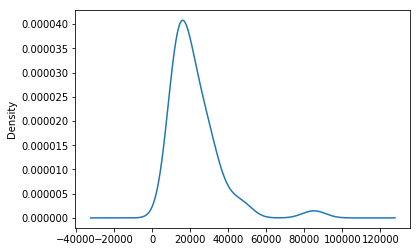

In [3]:
%matplotlib inline
import tushare
from matplotlib import pyplot as plt
 
df = tushare.get_hist_data("600680")
v = df[-90: ].volume
v.plot("kde")
plt.show()

近三个月，成交量大于200000就可以认为发生了异常（天量，嗯，要注意风险了……）

算法示例：

![h_code_1](h_code_1.jpg)

**2. 箱线图分析**

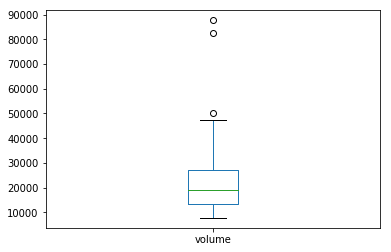

In [5]:
import tushare
from matplotlib import pyplot as plt
 
df = tushare.get_hist_data("600680")
v = df[-90: ].volume
v.plot("box")
plt.show()

大体可以知道，该股票在成交量少于20000，或者成交量大于80000，就应该提高警惕啦！

**3. 基于距离/密度**

典型的算法是：“局部异常因子算法-Local Outlier Factor”，该算法通过引入“k-distance，第k距离”、“k-distance neighborhood，第k距离邻域”、“reach-distance，可达距离”、以及“local reachability density，局部可达密度 ”和“local outlier factor，局部离群因子”，来发现异常点，可以参考https://blog.csdn.net/wangyibo0201/article/details/51705966

**4. 基于划分思想**

典型的算法是 “孤立森林，Isolation Forest”，其思想是：

>假设我们用一个随机超平面来切割（split）数据空间（data space）, 切一次可以生成两个子空间（想象拿刀切蛋糕一分为二）。之后我们再继续用一个随机超平面来切割每个子空间，循环下去，直到每子空间里面只有一个数据点为止。直观上来讲，我们可以发现那些密度很高的簇是可以被切很多次才会停止切割，但是那些密度很低的点很容易很早的就停到一个子空间了。

这个的算法流程即是使用超平面分割子空间，然后建立类似的二叉树的过程：
![h_code_2](h_code_2.jpg)

具体可以[参考](https://www.jianshu.com/p/5af3c66e0410)。

d:\programdata\anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
d:\programdata\anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
d:\programdata\anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
d:\programdata\anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
d:\programdata\anaconda3\lib\site-packages\sklearn\

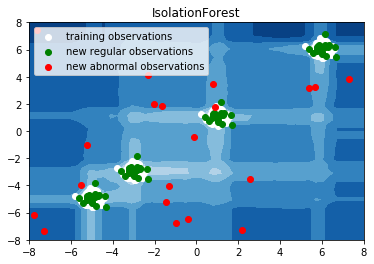

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

rng = np.random.RandomState(42)

# Generate train data
X = 0.3 * rng.randn(100, 2)
X_train = np.r_[X + 1, X - 3, X - 5, X + 6]
# Generate some regular novel observations
X = 0.3 * rng.randn(20, 2)
X_test = np.r_[X + 1, X - 3, X - 5, X + 6]
# Generate some abnormal novel observations
X_outliers = rng.uniform(low=-8, high=8, size=(20, 2))

# fit the model
clf = IsolationForest(max_samples=100*2, random_state=rng)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)

# plot the line, the samples, and the nearest vectors to the plane
xx, yy = np.meshgrid(np.linspace(-8, 8, 50), np.linspace(-8, 8, 50))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.title("IsolationForest")
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white')
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='green')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='red')
plt.axis('tight')
plt.xlim((-8, 8))
plt.ylim((-8, 8))
plt.legend([b1, b2, c],
           ["training observations",
            "new regular observations", "new abnormal observations"],
           loc="upper left")
plt.show()

结果如上，其中：红色即为异常点，白色是训练集，绿色是测试数据

注意：孤立森林不适用于特别高维的数据。由于每次切数据空间都是随机选取一个维度，建完树后仍然有大量的维度信息没有被使用，导致算法可靠性降低。高维空间还可能存在大量噪音维度或无关维度（irrelevant attributes），影响树的构建。孤立森林算法具有线性时间复杂度。因为是ensemble的方法，所以可以用在含有海量数据的数据集上面。通常树的数量越多，算法越稳定。由于每棵树都是互相独立生成的，因此可以部署在大规模分布式系统上来加速运算。

**5. 其他算法**

包括：One-class SVM 以及 Elliptic Envelope 等。

参考：[2.7. Novelty and Outlier Detection](https://scikit-learn.org/stable/modules/outlier_detection.html#novelty-and-outlier-detection)

**6. 值得一提**

这些算法里面，孤立森林和局部异常因子算法相比之下，效果是最好的。

其他:

- [参考1](https://www.jianshu.com/p/04c7c4a86ffd)
- [参考2](https://zhuanlan.zhihu.com/p/74508141)